In [2]:
import os
import time
path = os.path.abspath(os.getcwd())

In [3]:
# Data
import csv
import pandas as pd

pd.set_option("display.max_colwidth",100)
pd.set_option("display.max_rows",100)

In [4]:
# Randomness
import random as rd
import numpy as np
np.random.seed()
rd.seed()

from nistrng import check_eligibility_all_battery, run_all_battery, SP800_22R1A_BATTERY#, pack_sequence
from nistrng.sp800_22r1a import MonobitTest, FrequencyWithinBlockTest, RunsTest, LongestRunOnesInABlockTest, \
    DiscreteFourierTransformTest, NonOverlappingTemplateMatchingTest, SerialTest, ApproximateEntropyTest, \
    CumulativeSumsTest, RandomExcursionTest, RandomExcursionVariantTest

In [5]:
# Plots
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.style.use('ggplot')

# Set the default size of various textual elements
plt.rcParams['text.usetex'] = True  # Enable LaTeX rendering
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['text.color'] = '#000000'
plt.rcParams['axes.labelcolor'] = '#000000'
plt.rcParams['xtick.color'] = '#000000'
plt.rcParams['ytick.color'] = '#000000'

a, b, c = 18, 20, 24
plt.rcParams['font.size'] = b            # sets the default font size
plt.rcParams['axes.labelsize'] = c       # for x and y labels 
plt.rcParams['axes.titlesize'] = c       # for subplot titles
plt.rcParams['xtick.labelsize'] = a      # for x-axis tick labels
plt.rcParams['ytick.labelsize'] = a      # for y-axis tick labels
plt.rcParams['legend.fontsize'] = b      # for legend text

plt.rcParams['axes.labelpad'] = 15

In [6]:
# PARAMETERS
bitsize: np.uint32 = 32
mask: np.uint32 = np.uint32(2**bitsize - 1)

# I/ Preliminaries

In [147]:
def printif(verbose, string):
    if verbose:
        print(string)

In [148]:
def write_to_csv(filename, data):
    with open(filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)
        
def append_to_csv(filename, data):
    with open(filename, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(data)

## 1) Binary operations

In [149]:
def xor(a, b):
    return (np.uint32(a) ^ np.uint32(b)) & mask

In [150]:
def add(a, b): 
    with np.errstate(over='ignore'):  # suppresses overflow warnings
        result = np.uint32(a) + np.uint32(b)
    return result & mask

In [151]:
def bitrol(n, r):
    return ((np.uint32(n) << np.uint32(r)) & mask) | ((np.uint32(n) >> np.uint32(bitsize - r)) & mask)

In [152]:
def swab(value):
    if value < 0 or value > 0xFFFF:
        raise ValueError("Value must be a 16-bit unsigned integer")

    return np.uint32((value & np.uint32(0xFF)) << np.uint32(8)) | ((value & np.uint32(0xFF00)) >> np.uint32(8))

In [19]:
def pack_sequence_32(sequence: np.ndarray) -> np.ndarray:
    sequence_array = np.array(sequence, dtype=np.uint32)
    return np.unpackbits(sequence_array.view(np.uint8)).astype(np.uint8)

pack_sequence = pack_sequence_32

In [153]:
def binprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]: 
        s += bin(i) + ", "
    s += bin(pool[-1]) + "]"
    print(s)

In [154]:
def strprint(pool):
    s = "["
    for i in pool[0:len(pool)-1]: 
        s += str(i) + ", "
    s += str(pool[-1]) + "]"
    print(s)

## 2) Entropy gathering functions
### A. Half-SipHash

In [20]:
def hsiphash_perm(pool):
    assert(bitsize==32)
    rol32 = bitrol
    
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]
    
    a = add(a, b)
    b = rol32(b, 5)
    b = xor(b, a)
    a = rol32(a, 16)
    
    c = add(c, d)
    d = rol32(d, 8)
    d = xor(d, c)
    
    a = add(a, d)
    d = rol32(d, 7)
    d = xor(d, a)
    
    c = add(c, b)
    b = rol32(b, 13)
    b = xor(b, c)
    c = rol32(c, 16)
    
    return [a, b, c, d]

In [21]:
def siphash_mix(pool, input1, input2):
    pool[3] = xor(pool[3], input1)
    pool = hsiphash_perm(pool)
    pool[0] = xor(pool[0], input1)
    
    pool[3] = xor(pool[3], input2)
    pool = hsiphash_perm(pool)
    pool[0] = xor(pool[0], input2)
    
    return pool

In [22]:
hsiphash_init = [ np.uint32(0), np.uint32(0), np.uint32(0x6c796765), np.uint32(0x74656462) ]
def init_siphash_pool(): 
    return hsiphash_init.copy()

### B. Old Fast-Mix

In [161]:
def fast_mix_perm(pool):
    a, b, c, d = pool[0], pool[1], pool[2], pool[3]

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 6)
    d = bitrol(d, 27)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 16)
    d = bitrol(d, 14)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 6)
    d = bitrol(d, 27)
    d = xor(d, a)
    b = xor(b, c)

    a = add(a, b)
    c = add(c, d)
    b = bitrol(b, 16)
    d = bitrol(d, 14)
    d = xor(d, a)
    b = xor(b, c)

    return [a, b, c, d]

In [162]:
def fast_mix(pool, input1, input2, input3, input4):
    pool[0] ^= input1
    pool[1] ^= input2
    pool[2] ^= input3
    pool[3] ^= input4
    
    return fast_mix_perm(pool)

### C. Rotations

In [160]:
def rot_mix(pool, input1, input2, r): 
    pool = xor(pool, input1)
    pool = xor(pool, input2)
    pool = bitrol(pool, r)
    
    return pool

## 3) Models
### A. Timestamp

In [164]:
def draw_timestamp_params(N): 
    cauchy_gamma_array = np.random.uniform(4e4, 8e4, N)
    cauchy_x0_array = np.random.uniform(3e3, 8e3, N)
    cauchy_delta_array = np.random.uniform(2e7, 9e7, N)
    
    return cauchy_gamma_array, cauchy_x0_array, cauchy_delta_array

In [163]:
def draw_timestamp_theta(gamma, x0, size):
    cauchy_array = np.random.standard_cauchy(size) * gamma + x0
    return cauchy_array.astype(int)

### B. Jiffies

In [165]:
def init_jiffy_arrays():
    global jiffy_delta_distribution, jiffy_elements, jiffy_probabilities
    
    jiffy_delta_distribution = [
        [0, 0.419073], [1, 0.027795], [2, 0.004821],
        [3, 0.004008], [4, 0.455692], [5, 0.088511]
    ]

    jiffy_elements = [element for element, _ in jiffy_delta_distribution]
    jiffy_probabilities = [probability for _, probability in jiffy_delta_distribution]
    
init_jiffy_arrays()

In [ ]:
def draw_jiffy_deltas(N):
    drawn_elements = rd.choices(jiffy_elements, jiffy_probabilities, k=N)
    return [np.uint32(i) for i in drawn_elements]

def draw_jiffy_seed():
    if bitsize == 32:
        low, high = np.uint32(1e8), np.uint32(1e9)
    else:
        low, high = np.uint32(1e8), np.uint32(8e9)
    
    return rd.randrange(low, high)

def draw_jiffy_values(N):
    seed = draw_jiffy_seed()
    drawn_deltas = draw_jiffy_deltas(N)
    
    drawn_values = []
    for delta in drawn_deltas:
        seed += delta
        drawn_values.append(seed)
        
    return [np.uint32(i) for i in drawn_values]

### C. Instruction Pointer

In [168]:
def init_ip_arrays():
    global instruction_pointer_distribution, ip_elements, ip_probabilities
    
    instruction_pointer_distribution = [
        [4112549988, 0.729635], [3995109476, 0.177747], [3709896804, 0.072718],
        [4005702796, 0.010259], [3995352108, 0.004920], [4005727176, 0.000448],
        [4246767716, 0.000396], [4123167688, 0.000297], [4112865224, 0.000261],
        [3995247160, 0.000223], [3995185056, 0.000115], [4112960576, 0.000110],
        [4112786712, 0.000072], [4113351664, 0.000070], [4123167300, 0.000070],
        [3720514504, 0.000058], [3710212040, 0.000053], [3712703804, 0.000050],
        [3995424712, 0.000050], [4113352520, 0.000048]
    ]

    ip_elements = [element for element, _ in instruction_pointer_distribution]
    ip_probabilities = [probability for _, probability in instruction_pointer_distribution]

init_ip_arrays()

In [169]:
def draw_ip_values(N):
    drawn_elements = rd.choices(ip_elements, ip_probabilities, k=N)
    return [np.uint32(i) for i in drawn_elements]

[3995109476, 4112549988, 4112549988]

#### Simulating IP values

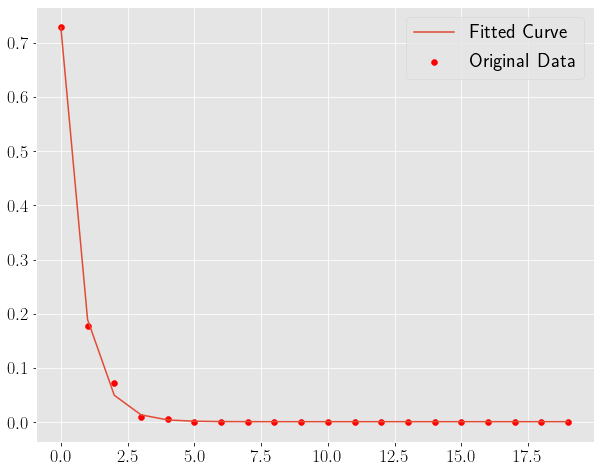

In [170]:
xdata = list(range(len(instruction_pointer_distribution)))
ydata = [point[1] for point in instruction_pointer_distribution]

# Double exponential fitting
def double_exponential(x, a, b, c):
    return a * np.exp(b * x) + c 
ip_params, covariance = curve_fit(double_exponential, xdata, ydata, p0=(1, -1, 1))

plt.scatter(xdata, ydata, color="red", label="Original Data")
plt.plot(xdata, [double_exponential(x, *ip_params) for x in xdata], label="Fitted Curve")
plt.legend()
plt.show()

In [171]:
def generate_ip_probabilities(n, ip_params):
    noise = np.random.uniform(0.8, 1.2, n)
    probabilities = [double_exponential(x, *ip_params)*noise[i] for i,x in enumerate(range(n))]
    
    # Normalize the probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
    
    # Generate n data points
    low, high = int(37e8), int(43e8)
    data_points = np.random.default_rng().integers(low, high, size=n)
    
    return [[data_points[i], probabilities[i]] for i in range(n)]

In [172]:
def generate_ip_arrays(n):
    global ip_elements, ip_probabilities
    
    generated_ip = generate_ip_probabilities(n, ip_params)
    sorted_ip = sorted(generated_ip, key=lambda x: x[1], reverse=True)
    
    ip_elements = [element for element, _ in sorted_ip]
    ip_probabilities = [probability for _, probability in sorted_ip]

In [173]:
generate_ip_arrays(20)
draw_ip_values(3)

[4132387984, 4132387984, 4132387984]

### C. IRQ

In [174]:
def init_irq_arrays():
    global irq_distribution, irq_elements, irq_probabilities
    
    irq_distribution = [
        [90, 0.563053], [76, 0.052640], [77, 0.049272],
        [10, 0.044676], [70, 0.038246], [75, 0.035131],
        [69, 0.033727], [73, 0.033374], [72, 0.029866],
        [71, 0.026564], [74, 0.024222], [67, 0.018798],
        [78, 0.017512], [68, 0.014154], [89, 0.011819]
    ]

    irq_elements = [element for element, _ in irq_distribution]
    irq_probabilities = [probability for _, probability in irq_distribution]
    
init_irq_arrays()

In [175]:
def draw_irq_values(N):
    drawn_elements = rd.choices(irq_elements, irq_probabilities, k=N)
    return [np.uint32(i) for i in drawn_elements]

[90, 90, 90]

#### Simulating IRQ values

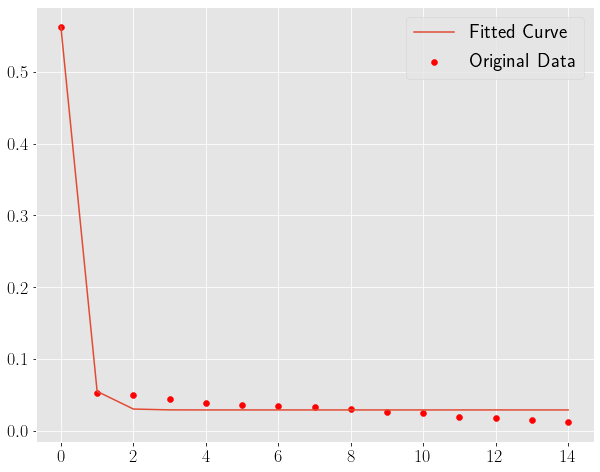

In [176]:
xdata = list(range(len(irq_distribution)))
ydata = [point[1] for point in irq_distribution]

# Double exponential fitting
def double_exponential(x, a, b, c):
    return a * np.exp(b * x) + c 
irq_params, covariance = curve_fit(double_exponential, xdata, ydata, p0=(1, -1, 1))

plt.scatter(xdata, ydata, color="red", label="Original Data")
plt.plot(xdata, [double_exponential(x, *irq_params) for x in xdata], label="Fitted Curve")
plt.legend()
plt.show()

In [177]:
def generate_irq_probabilities(n, irq_params):
    noise = np.random.uniform(0.8, 1.2, n)
    probabilities = [double_exponential(x, *irq_params)*noise[i] for i,x in enumerate(range(n))]
    
    # Normalize the probabilities
    total_prob = sum(probabilities)
    probabilities = [p / total_prob for p in probabilities]
    
    # Generate n data points
    data_points = np.random.default_rng().integers(1, 100, size=n)
    
    return [[data_points[i], probabilities[i]] for i in range(n)]

In [178]:
def generate_irq_arrays(n):
    global irq_elements, irq_probabilities
    generated_irq = generate_irq_probabilities(n, ip_params)
    sorted_irq = sorted(generated_irq, key=lambda x: x[1], reverse=True)
    
    irq_elements = [element for element, _ in sorted_irq]
    irq_probabilities = [probability for _, probability in sorted_irq]

In [179]:
generate_irq_arrays(20)
draw_irq_values(3)

[52, 52, 52]

# II/ Simulation

In [186]:
chosen_tests: dict = {
    'monobit': MonobitTest(),
    'frequency_within_block': FrequencyWithinBlockTest(),
    'runs': RunsTest(),                                                        #unreliable
    'longest_run_ones_in_a_block': LongestRunOnesInABlockTest(),
#     'dft': DiscreteFourierTransformTest(),                                     #unapplicable
    'non_overlapping_template_matching': NonOverlappingTemplateMatchingTest(), #unreliable
    'serial': SerialTest(),                                                    #slow 
    'approximate_entropy': ApproximateEntropyTest(),                           #slow
    'cumulative sums': CumulativeSumsTest(),                                   #unreliable
    'random_excursion': RandomExcursionTest(),
#     'random_excursion_variant': RandomExcursionVariantTest()                   #unapplicable
}

In [187]:
def score_to_rating(score: float) -> float:
    difference = abs(score - 0.5)
    rating = 1 - 2 * difference
    return rating**2

## A. Siphash

In [188]:
def make_siphash_sim(gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ init_siphash_pool() for _ in range(N)]
    output = []
    
    generate_ip_arrays(20), generate_irq_arrays(20)
    delta_values = np.array([np.uint32(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint32(0) for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint32(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
        
        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        irq_values = draw_irq_values(N)
        
        # Calling fast_mix
        for i in range(N): 
            pools[i] = siphash_mix(pools[i], timestamp_values[i], ip_values[i] ^ swab(irq_values[i]))
                
        flat_pool = np.concatenate(pools)
        binary_sequence = pack_sequence(flat_pool)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["siphash", gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [189]:
make_siphash_sim(400, 0, 38229868, 8, 5000, chosen_tests, True)  

Round0
	 - PASSED - score: 0.747 - Monobit - elapsed time: 3 ms
	 - PASSED - score: 0.493 - Frequency Within Block - elapsed time: 5 ms
	 - PASSED - score: 0.272 - Runs - elapsed time: 100 ms
	 - PASSED - score: 0.055 - Longest Run Ones In A Block - elapsed time: 7 ms
	 - FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 44 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1168 ms
	 - PASSED - score: 0.582 - Serial - elapsed time: 16067 ms
	 - PASSED - score: 0.773 - Approximate Entropy - elapsed time: 21145 ms
	 - PASSED - score: 1.0 - Cumulative Sums - elapsed time: 571 ms
	 - PASSED - score: 0.879 - Random Excursion - elapsed time: 1494 ms
Round1
	 - PASSED - score: 0.026 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.025 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.423 - Runs - elapsed time: 179 ms
	 - PASSED - score: 0.737 - Longest Run Ones In A Block - elapsed time: 10 ms
	 - FAILED - score: 0.0 - Discrete 

[['siphash', 400, 0, 38229868, 0, 'Monobit', 0.7470739377544711, True],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Frequency Within Block',
  0.4934877228498445,
  True],
 ['siphash', 400, 0, 38229868, 0, 'Runs', 0.27236600609853284, True],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.05464340877433612,
  True],
 ['siphash', 400, 0, 38229868, 0, 'Discrete Fourier Transform', 0.0, False],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999999998746081,
  True],
 ['siphash', 400, 0, 38229868, 0, 'Serial', 0.5824753438893796, True],
 ['siphash',
  400,
  0,
  38229868,
  0,
  'Approximate Entropy',
  0.7727651015004625,
  True],
 ['siphash', 400, 0, 38229868, 0, 'Cumulative Sums', 1.0, True],
 ['siphash', 400, 0, 38229868, 0, 'Random Excursion', 0.878695388450189, True],
 ['siphash', 400, 0, 38229868, 1, 'Monobit', 0.025747442877204055, True],
 ['siphash',
  400,
  0,
  38229868,
  1,
  'Frequency Within Block',
  0

In [190]:
make_siphash_sim(48031, 3818, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - PASSED - score: 0.99 - Monobit - elapsed time: 17 ms
	 - PASSED - score: 0.46 - Frequency Within Block - elapsed time: 1 ms
	 - PASSED - score: 0.035 - Runs - elapsed time: 124 ms
	 - PASSED - score: 0.328 - Longest Run Ones In A Block - elapsed time: 16 ms
	 - FAILED - score: 0.0 - Discrete Fourier Transform - elapsed time: 47 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 1252 ms
	 - PASSED - score: 0.081 - Serial - elapsed time: 18111 ms
	 - PASSED - score: 0.3 - Approximate Entropy - elapsed time: 23367 ms
	 - PASSED - score: 1.0 - Cumulative Sums - elapsed time: 554 ms
	 - FAILED - score: 0.63 - Random Excursion - elapsed time: 1374 ms
Round1
	 - PASSED - score: 0.428 - Monobit - elapsed time: 16 ms
	 - PASSED - score: 0.965 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.872 - Runs - elapsed time: 121 ms
	 - PASSED - score: 0.945 - Longest Run Ones In A Block - elapsed time: 7 ms
	 - FAILED - score: 0.0 - Discrete Fou

[['siphash', 48031, 3818, 38229868, 0, 'Monobit', 0.9900267027119241, True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Frequency Within Block',
  0.4599242249280657,
  True],
 ['siphash', 48031, 3818, 38229868, 0, 'Runs', 0.03464360265399147, True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.3275336286437616,
  True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Discrete Fourier Transform',
  0.0,
  False],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999999999869091,
  True],
 ['siphash', 48031, 3818, 38229868, 0, 'Serial', 0.08057126296261816, True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Approximate Entropy',
  0.2997990969335274,
  True],
 ['siphash', 48031, 3818, 38229868, 0, 'Cumulative Sums', 1.0, True],
 ['siphash',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion',
  0.630213022379425,
  False],
 ['siphash', 48031, 3818, 38229868, 1, 'Monobit', 0.4280691917681947

## B. Old fast_mix

In [43]:
def make_fast_mix_sim(gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ [np.uint32(0) for i in range(4) ] for _ in range(N)]
    output = []
    
    generate_ip_arrays(20), generate_irq_arrays(20)
    jiffy_values = np.array([np.uint32(0) for _ in range(N)])
    delta_values = np.array([np.uint32(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint32(0) for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint32(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
        
        #Generating jiffies with jdelta
        jdelta_values = draw_jiffy_deltas(N)
        jiffy_values = [np.uint32(jiffy_values[i] + jdelta_values[i]) & mask for i in range(N)]
        
        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        irq_values = draw_irq_values(N)
        
        # Calling fast_mix
        for i in range(N): 
            c_high = timestamp_values[i] >> np.uint32(32)
            j_high = jiffy_values[i] >> np.uint32(32)
            
            pools[i] = fast_mix(pools[i], timestamp_values[i] ^ j_high ^ irq_values[i], jiffy_values[i] ^ c_high,
                               ip_values[i], ip_values[i]>>np.uint32(32))
                
        flat_pool = np.concatenate(pools)
        binary_sequence = pack_sequence(flat_pool)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["fast_mix", gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [44]:
make_fast_mix_sim(400, 0, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.067 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 72 ms
	 - PASSED - score: 0.235 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 806 ms
	 - PASSED - score: 0.971 - Random Excursion - elapsed time: 827 ms
Round1
	 - PASSED - score: 0.142 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.069 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.893 - Runs - elapsed time: 73 ms
	 - PASSED - score: 0.838 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 805 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 835 ms
Round2
	 - PASSED - score: 0.832 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.2 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.331 - Runs

[['fast_mix', 400, 0, 38229868, 0, 'Monobit', 1.4802447135575433e-07, False],
 ['fast_mix',
  400,
  0,
  38229868,
  0,
  'Frequency Within Block',
  0.0667788010514162,
  True],
 ['fast_mix', 400, 0, 38229868, 0, 'Runs', 0.00041456565337783923, False],
 ['fast_mix',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.23538249410215892,
  True],
 ['fast_mix',
  400,
  0,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999999992968119,
  True],
 ['fast_mix',
  400,
  0,
  38229868,
  0,
  'Random Excursion',
  0.9709603488313201,
  True],
 ['fast_mix', 400, 0, 38229868, 1, 'Monobit', 0.14156175398337104, True],
 ['fast_mix',
  400,
  0,
  38229868,
  1,
  'Frequency Within Block',
  0.06927970183027073,
  True],
 ['fast_mix', 400, 0, 38229868, 1, 'Runs', 0.8927705354770372, True],
 ['fast_mix',
  400,
  0,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.837817056843309,
  True],
 ['fast_mix',
  400,
  0,
  38229868,
  1,
  'Non Overlapping Template Matc

In [45]:
make_fast_mix_sim(48031, 3818, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - PASSED - score: 0.601 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.518 - Frequency Within Block - elapsed time: 1 ms
	 - PASSED - score: 0.459 - Runs - elapsed time: 71 ms
	 - PASSED - score: 0.881 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 805 ms
	 - FAILED - score: 0.755 - Random Excursion - elapsed time: 841 ms
Round1
	 - PASSED - score: 0.257 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.203 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.941 - Runs - elapsed time: 72 ms
	 - PASSED - score: 0.044 - Longest Run Ones In A Block - elapsed time: 5 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 686 ms
	 - PASSED - score: 0.879 - Random Excursion - elapsed time: 835 ms
Round2
	 - PASSED - score: 0.928 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.331 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.205 

[['fast_mix', 48031, 3818, 38229868, 0, 'Monobit', 0.6013222464534647, True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  0,
  'Frequency Within Block',
  0.5180154102645981,
  True],
 ['fast_mix', 48031, 3818, 38229868, 0, 'Runs', 0.4590927609725284, True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.8808287544329111,
  True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9999999999542044,
  True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion',
  0.7549490872383465,
  False],
 ['fast_mix', 48031, 3818, 38229868, 1, 'Monobit', 0.25742428438288234, True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  1,
  'Frequency Within Block',
  0.2027870047220209,
  True],
 ['fast_mix', 48031, 3818, 38229868, 1, 'Runs', 0.9409281545991254, True],
 ['fast_mix',
  48031,
  3818,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.043699687102284196,
  True],
 ['fast_mix',
  48031,
  3818,
  

## C. Rotations

In [46]:
def make_rotation_sim(rot, gamma, x0, delay, rounds, N, tests, verbose): 
    pools = [ np.uint32(0) for _ in range(N)]
    output = []
    
    delta_values = np.array([np.uint32(delay) for _ in range(N)])
    timestamp_values = np.array([np.uint32(0) for _ in range(N)])
    
    for r in range(rounds): 
        printif(verbose, "Round" + str(r))
        
        # Generating timestamp with Theta & Delta
        theta_values = np.array(generate_cauchy(gamma, x0, N))
        delta_values = delta_values + theta_values
        timestamp_values = [np.uint32(timestamp_values[i] + delta_values[i]) & mask for i in range(N)]
            
        # Drawing IP and IRQ
        ip_values = draw_ip_values(N)
        
        for i in range(N): 
            pools[i] = rot_mix(pools[i], timestamp_values[i], ip_values[i], rot)
        
        binary_sequence = pack_sequence(pools)
        
        if tests == None: 
            eligible_battery: dict = check_eligibility_all_battery(
                binary_sequence, SP800_22R1A_BATTERY)
            tests = eligible_battery
            
        results = run_all_battery(binary_sequence, tests, False)
        
        for result, elapsed_time in results:            
            output.append(["rot"+str(rot), gamma, x0, delay, r, result.name, result.score, result.passed])
            if result.passed:
                printif(verbose, "\t - PASSED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")
            else:
                printif(verbose, "\t - FAILED - score: " + str(np.round(result.score, 3)) + " - " + result.name + " - elapsed time: " + str(elapsed_time) + " ms")

    return output

In [47]:
# make_rotation_sim(18, 400, 0, 38229868, 8, 5000, chosen_tests, True)
make_rotation_sim(18, 400, 0, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 18 ms
	 - PASSED - score: 0.305 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 207 ms
	 - PASSED - score: 0.879 - Random Excursion - elapsed time: 197 ms
Round1
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 18 ms
	 - PASSED - score: 0.084 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 0.999 - Non Overlapping Template Matching - elapsed time: 192 ms
	 - PASSED - score: 0.957 - Random Excursion - elapsed time: 198 ms
Round2
	 - FAILED - score: 0.0 - Monobit - elapsed time: 0 ms
	 - FAILED - score: 0.009 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.004 - Runs - ela

[['rot18', 400, 0, 38229868, 0, 'Monobit', 1.412483250513391e-52, False],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Frequency Within Block',
  8.553621682942628e-20,
  False],
 ['rot18', 400, 0, 38229868, 0, 'Runs', 6.149756030471296e-18, False],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.3047928828384625,
  True],
 ['rot18',
  400,
  0,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9998739706888167,
  True],
 ['rot18', 400, 0, 38229868, 0, 'Random Excursion', 0.878695388450189, True],
 ['rot18', 400, 0, 38229868, 1, 'Monobit', 8.072258323241464e-110, False],
 ['rot18',
  400,
  0,
  38229868,
  1,
  'Frequency Within Block',
  1.1353809530362061e-69,
  False],
 ['rot18', 400, 0, 38229868, 1, 'Runs', 7.607904175581429e-128, False],
 ['rot18',
  400,
  0,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.08445972627815855,
  True],
 ['rot18',
  400,
  0,
  38229868,
  1,
  'Non Overlapping Template Matching',
  0.9989726811556039,
  T

In [48]:
# make_rotation_sim(18, 48031, 3818, 38229868, 8, 5000, chosen_tests, True)
make_rotation_sim(18, 48031, 3818, 38229868, 8, 5000, chosen_tests, True)

Round0
	 - FAILED - score: 0.0 - Monobit - elapsed time: 1 ms
	 - FAILED - score: 0.0 - Frequency Within Block - elapsed time: 0 ms
	 - FAILED - score: 0.0 - Runs - elapsed time: 18 ms
	 - FAILED - score: 0.0 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 0.933 - Non Overlapping Template Matching - elapsed time: 202 ms
	 - PASSED - score: 0.879 - Random Excursion - elapsed time: 200 ms
Round1
	 - PASSED - score: 0.708 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.328 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.583 - Runs - elapsed time: 18 ms
	 - PASSED - score: 0.693 - Longest Run Ones In A Block - elapsed time: 4 ms
	 - PASSED - score: 1.0 - Non Overlapping Template Matching - elapsed time: 195 ms
	 - PASSED - score: 0.971 - Random Excursion - elapsed time: 200 ms
Round2
	 - PASSED - score: 0.215 - Monobit - elapsed time: 0 ms
	 - PASSED - score: 0.953 - Frequency Within Block - elapsed time: 0 ms
	 - PASSED - score: 0.769 - Runs

[['rot18', 48031, 3818, 38229868, 0, 'Monobit', 1.1942608226331576e-74, False],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Frequency Within Block',
  3.1724988434598755e-38,
  False],
 ['rot18', 48031, 3818, 38229868, 0, 'Runs', 3.302067903039104e-34, False],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Longest Run Ones In A Block',
  0.00041675784191207827,
  False],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Non Overlapping Template Matching',
  0.9334963895704067,
  True],
 ['rot18',
  48031,
  3818,
  38229868,
  0,
  'Random Excursion',
  0.878695388450189,
  True],
 ['rot18', 48031, 3818, 38229868, 1, 'Monobit', 0.7076604666545525, True],
 ['rot18',
  48031,
  3818,
  38229868,
  1,
  'Frequency Within Block',
  0.32793702886992304,
  True],
 ['rot18', 48031, 3818, 38229868, 1, 'Runs', 0.5825601978744768, True],
 ['rot18',
  48031,
  3818,
  38229868,
  1,
  'Longest Run Ones In A Block',
  0.6931588933780084,
  True],
 ['rot18',
  48031,
  3818,
  38229868,
  1,
  '

## C. Averaged result

In [49]:
def init_csv(outfile):
    write_to_csv(outfile, [['function','gamma','x0','delay','round','test','score','passed']])

In [50]:
def run_simulation(gamma, x0, delay, rounds, N, repeats, outfile):
    for r in range(repeats):
        print(">Repeat "+str(r+1)+" of "+str(repeats))
        
        output = make_siphash_sim(gamma, x0, delay, rounds, N, chosen_tests, False)
        append_to_csv(outfile, output)
        print('\tSiphash done.')
        
        output = make_fast_mix_sim(gamma, x0, delay, rounds, N, chosen_tests, False)
        append_to_csv(outfile, output)
        print('\tFast_mix done.')

        for rot in range(bitsize - 1):
            output = make_rotation_sim(rot+1, gamma, x0, delay, rounds, N, chosen_tests, False) 
            append_to_csv(outfile, output)
            print('\tRot ' + str(rot+1) + " done.")

In [51]:
def testing_32(outfile):
    if bitsize == 32:
        init_csv(outfile)
        
        N=100
        cauchy_gamma_array, cauchy_x0_array, cauchy_delta_array = draw_cauchy_params(N)
        
        for i in range(N):
            print("Run " + str(i+1) + " of " + str(N))
            run_simulation(cauchy_gamma_array[i], cauchy_x0_array[i], cauchy_delta_array[i], 
                           10, 32000, 1, outfile)
        
        run_simulation(48031, 3818, 38229868, 8, 32000, 1, outfile)
        run_simulation(48125, 3804, 38229868, 8, 32000, 1, outfile)
        run_simulation(444592, -2986, 572059897, 8, 32000, 1, outfile)
        run_simulation(47339, 7476, 38228910, 8, 32000, 1, outfile)
        run_simulation(73323, 5263, 38228910, 8, 32000, 1, outfile)
    
testing_32('out\\32bits\\out32.1.csv')

Run 1 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 2 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 3 of 100
>Repeat 1 of 1
	Sip

	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 18 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 19 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	R

	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 35 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 36 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	R

	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 52 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 53 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	R

	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 69 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 70 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	R

	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 86 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
Run 87 of 100
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	R

	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	Rot 20 done.
	Rot 21 done.
	Rot 22 done.
	Rot 23 done.
	Rot 24 done.
	Rot 25 done.
	Rot 26 done.
	Rot 27 done.
	Rot 28 done.
	Rot 29 done.
	Rot 30 done.
	Rot 31 done.
>Repeat 1 of 1
	Siphash done.
	Fast_mix done.
	Rot 1 done.
	Rot 2 done.
	Rot 3 done.
	Rot 4 done.
	Rot 5 done.
	Rot 6 done.
	Rot 7 done.
	Rot 8 done.
	Rot 9 done.
	Rot 10 done.
	Rot 11 done.
	Rot 12 done.
	Rot 13 done.
	Rot 14 done.
	Rot 15 done.
	Rot 16 done.
	Rot 17 done.
	Rot 18 done.
	Rot 19 done.
	R

# III/ Result analysis

In [7]:
def import_csv(filename): 
    data_path = path + "\\" + filename + ".csv"
    data = pd.read_csv(data_path)
        
    return data

## A. Data compiling

In [8]:
def compile_csv_files(directory_path):
    csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
    
    if not csv_files:
        print("No CSV files found in the directory.")
        return
    
    dataframes = []
    
    for file in csv_files:
        file_path = os.path.join(directory_path, file)
        data = pd.read_csv(file_path)
        data['File Name'] = os.path.splitext(file)[0]  # Add file name as a new column
        dataframes.append(data)
    
    combined_data = pd.concat(dataframes, ignore_index=True)
    
    output_path = os.path.join(directory_path, "master_file.csv")
    combined_data.to_csv(output_path, index=False)
    print(f"Master file created: {output_path}")

In [9]:
path32 = path + "\\out\\32bits" 
compile_csv_files(path32)

Master file created: C:\Users\Abouez\OneDrive\Documents\Alexandre\PhD\Projects\Entropy gathering\out\32bits\master_file.csv


## B. Data processing

In [15]:
filename32 = 'out\\32bits\\master_file'
data32 = import_csv(filename32)
data32.columns

Index(['function', 'gamma', 'x0', 'delay', 'round', 'test', 'score', 'passed',
       'File Name', 'pools'],
      dtype='object')

In [16]:
data_average = data32.groupby(['function', 'round'])['score'].mean().reset_index()
# data_average['rating'] = data_average['score'].apply(score_to_rating)
data_average

,function,round,score
0,fast_mix,0,0.429915
1,fast_mix,1,0.615443
2,fast_mix,2,0.622911
3,fast_mix,3,0.634115
4,fast_mix,4,0.641438
...,...,...,...
325,siphash,5,0.628414
326,siphash,6,0.607372
327,siphash,7,0.606585
328,siphash,8,0.626400


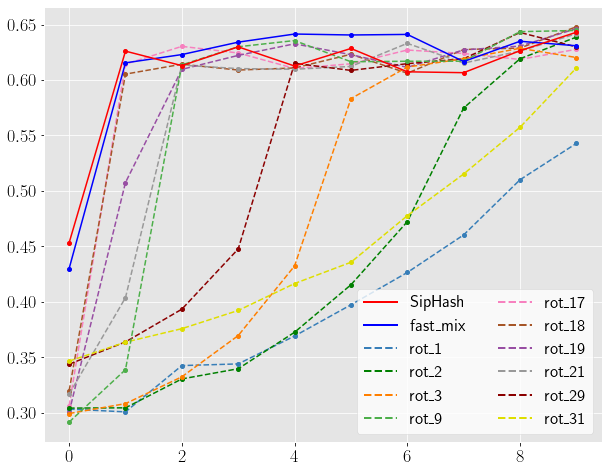

In [17]:
data_grouped = data_average.groupby(['function'])

CB_cycle = ['red', 'blue','#377eb8', 
            'green' ,'#ff7f00', '#4daf4a',
            '#f781bf', '#a65628', '#984ea3',
            '#999999', 'darkred', '#dede00']

legend = ['SipHash', 'fast\_mix', 'rot\_1', 
          'rot\_2', 'rot\_3', 'rot\_9', 
          'rot\_17', 'rot\_18', 'rot\_19', 
          'rot\_21', 'rot\_29', 'rot\_31']
lines = {
    'siphash': (CB_cycle[0], 2, '-'),
    'fast_mix': (CB_cycle[1], 2, '-'),
    'rot1': (CB_cycle[2], 1, '--'),
    'rot2': (CB_cycle[3], 1, '--'),
    'rot3': (CB_cycle[4], 1, '--'),
    'rot9': (CB_cycle[5], 1, '--'),
    'rot17': (CB_cycle[6], 1, '--'),
    'rot18': (CB_cycle[7], 1, '--'),
    'rot19': (CB_cycle[8], 1, '--'),
    'rot21': (CB_cycle[9], 1, '--'),
    'rot29': (CB_cycle[10], 1, '--'),
    'rot31': (CB_cycle[11], 1, '--')
}

plt.figure()
for name, group in data_grouped:
    if name in lines:
        plt.plot(group['round'], group['score'], marker='o', linestyle=lines[name][2], ms=4, 
                 color=lines[name][0], zorder=lines[name][1])

legend_lines = []
for x in CB_cycle[:2]: 
    legend_lines.append(Line2D([0], [0], color=x, lw=2, linestyle='-'))
for x in CB_cycle[2:]: 
    legend_lines.append(Line2D([0], [0], color=x, lw=2, linestyle='--'))

plt.legend(legend_lines, legend, loc='lower right', fontsize='small', facecolor='white', ncol=2)
plt.show()

In [18]:
test = data_average[data_average['round'] == 4]
test.sort_values('score')

,function,round,score
14,rot1,4,0.369096
124,rot2,4,0.372497
254,rot31,4,0.416433
234,rot3,4,0.432302
244,rot30,4,0.451629
154,rot22,4,0.603096
164,rot23,4,0.603616
74,rot15,4,0.608706
144,rot21,4,0.609680
94,rot17,4,0.610408


In [19]:
filtered_data = data_average[data_average['round'] > 2]
average_per_function = filtered_data.groupby('function')['score'].mean()
sorted_functions = average_per_function.sort_values()
# sorted_functions